# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.



---




### <font color='blue'>Assignment 14: LSTM ON AMAZON FINE FOOD REVIEWS</font>

**key points:**


*   In this assignment total 100k points are considered for classification task.
*   For pretrained weights for embedding layer glove.6B.100d are used(100 dimesional word embeddings).
*   The create model function is designed for maximum upto 2 LSTM layers and 1 output layer (sigmoid).
* . For validation_data the test data is used.

---




In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import numpy as np
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import re
from tqdm import tqdm_notebook as tqdm
import time
from sklearn.feature_extraction.text import CountVectorizer

from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense,BatchNormalization,Dropout
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.initializers import he_uniform,random_normal
from keras.activations import sigmoid
from keras.optimizers import Adam
from keras.utils import plot_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 377.0MB 47kB/s 


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 97% 242M/251M [00:03<00:00, 65.3MB/s]
100% 251M/251M [00:04<00:00, 65.3MB/s]


In [ ]:
!unzip /content/amazon-fine-food-reviews.zip

Archive:  /content/amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [ ]:
import tensorflow
print(tensorflow.test.gpu_device_name())
print(tensorflow.__version__)

/device:GPU:0
1.14.0




---



# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
filtered_data = pd.read_csv("/content/Reviews.csv") 


filtered_data=filtered_data[filtered_data['Score']!=3][:100000]

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
filtered_data[filtered_data['UserId']=="AR5J8UI46CURR"].head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
73790,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
78444,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,1,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

(87775, 10)


87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
filtered_data[filtered_data['Id']==64422]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

## [3] NULL Values Removal/subsitution

In [ ]:
print(final.isnull().any())
final['UserId'].fillna("",inplace=True)
final['Summary'].fillna("",inplace=True)

Id                        False
ProductId                 False
UserId                    False
ProfileName                True
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                    True
Text                      False
dtype: bool


In [ ]:
print("our final data size")
print(final.shape)

our final data size
(87773, 10)




---



## [4] Data preprocessing

## [4.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords

After which we collect the words used to describe positive and negative reviews

In [ ]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
StopWords=set(stopwords.words('english'))
StopWords.add('no')
StopWords.add('nor')
StopWords.add('not')
StopWords.add('br')

preprocessed_reviews=[]
for sentence in tqdm((final["Text"].values)):
  #removing urls
  sentence = re.sub(r"http\S+", "", sentence)
  #removing html tags
  sentence = BeautifulSoup(sentence, 'lxml').get_text()
  #resolving short word notations
  sentence = decontracted(sentence)
  #removing punctuations fullstops commas (except alphanumeric)
  sentence=re.sub('[^A-Za-z0-9]+', ' ', sentence)
  #removing words with numbers
  sentence = re.sub("\S*\d\S*", "", sentence).strip()
  sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in StopWords)
  preprocessed_reviews.append(sentence)
  
  
  

In [ ]:
#dropping the TEXT column and adding the preprocessed column in our dataframe
#we will only keep the preprocessed text part as our data
final.drop(["Text"],axis=1,inplace=True)
final["Text"]=preprocessed_reviews



---



## [5] Train-Test Split(we only consider text data )

In [ ]:
y=final["Score"].values
X=final["Text"].values

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2)

print("train data shape ",X_train.shape)
print("test data shape ",X_test.shape)

train data shape  (70218,)
test data shape  (17555,)


## [6]Vectorization Of Train Text Data

In [ ]:
#collecting vocabulary from the train data
vocab=[]
for sentence in X_train:
  vocab.extend(sentence.split(" "))

word_freq=sorted(dict(Counter(vocab)).items(),key=lambda kv:kv[1],reverse=True)
#getting top 10 words by frequency
print(word_freq[:20])

#creating a list of top words in that order and picking top 5000 words only
top_words=list(dict(word_freq).keys())[:5000]

[('like', 30822), ('good', 24486), ('one', 21108), ('great', 20896), ('taste', 20384), ('would', 19060), ('coffee', 18259), ('product', 18241), ('flavor', 17161), ('tea', 15566), ('love', 15520), ('food', 14402), ('get', 12938), ('really', 12132), ('amazon', 11229), ('much', 10929), ('time', 10259), ('also', 10155), ('use', 10103), ('little', 9915)]


In [ ]:
#doing vectorization of train data
vec_all_train=[]
for sentence in tqdm(X_train):
  vec=[]
  for word in sentence.split(" "):
    if word  not in top_words:
      pass
    else :
    
     vec.append(top_words.index(word)+1)
  vec_all_train.append(vec)
    


In [ ]:
#vectorizing test data
vec_all_test=[]
for sentence in tqdm(X_test):
  vec=[]
  for word in sentence.split(" "):
    if word  not in top_words:
      pass
    else :
    
     vec.append(top_words.index(word)+1)
  vec_all_test.append(vec)

In [ ]:
#checking if all train and test reviews has been converted to vector

print("all train reviews has been converted to vector ",len(X_train)==len(vec_all_train))
print("all test rviews has been converted to vector ",len(X_test)==len(vec_all_test))

all train reviews has been converted to vector  True
all test rviews has been converted to vector  True


In [ ]:
X_train_new=np.array(vec_all_train)
X_test_new=np.array(vec_all_test)

print(X_train_new[3])
print(type(X_train_new[3]))
print(len(X_train_new[3]))

[1, 38, 1454, 2, 168, 7, 5, 76, 86, 561, 970, 1442, 970, 1, 32, 409, 491, 359, 22, 92, 132, 488, 22, 208, 23, 1287, 540, 817, 96]
<class 'list'>
29


In [ ]:
# truncate and/or pad input sequences
max_review_length = 600
X_train_new = sequence.pad_sequences(X_train_new, maxlen=max_review_length)
X_test_new = sequence.pad_sequences(X_test_new, maxlen=max_review_length)

print(X_train_new.shape)
print(X_train_new[1])

(70218, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    



---

###setting pretrained glove vectors as weights.

In [ ]:
#Getting Pretrained Glove vectors as weights for Embedding layer
#https://stackoverflow.com/a/52148109

!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-09-08 07:57:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-09-08 07:57:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-09-08 07:57:47--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
#we are using the 100 dimensional pretrained glove vectorization
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.



Found 400000 word vectors.


In [ ]:
#creating weight matrix 
weights=np.zeros((len(top_words)+1,100))

#getting word and index from top 5k words
for index,word in tqdm(enumerate(list(dict(word_freq).keys())[:5000])):
  
  
  #getting the 100-D glove representation for the word
  try:
    
    vec=embeddings_index[word]
  except:
    vec=np.zeros(100)
  
  #inserting the 100D vector to the row corresponding to the rank of the word
  
  weights[index+1]=vec



---



In [ ]:
def plot_graph(history,model):
  print("test log-loss ",model.evaluate(X_test_new,y_test,verbose=0)[0])
  print("test accuracy ",model.evaluate(X_test_new,y_test,verbose=0)[1])
  plt.figure(figsize=(16,6))
  for i in range(1,3):
    plt.subplot(1,2,i)
    
    if i==1:
      plt.plot(np.arange(1,epochs+1),history.history['loss'],label="Train Loss")
      plt.plot(np.arange(1,epochs+1),history.history['val_loss'],label="Test Loss")
      plt.ylabel("cross entropy loss")
    else:
      plt.plot(np.arange(1,epochs+1),history.history['acc'],label="Train Accuracy")
      plt.plot(np.arange(1,epochs+1),history.history['val_acc'],label="Test Accuracy")
      plt.ylabel("Accuracy")
    plt.xlabel("number of epochs")
    
    plt.legend()
  plt.suptitle("Error Plots")
  
  plt.show()

In [ ]:
#here we are defining what is the size of vector for each word
vec_for_each_word=32
epochs=10
batch_size=200

#the length of one text/review after padding
sequence_length=600

vocab_size=len(top_words)+1

## [7] Creating Our LSTM Models

### [7.1] Creating a Simple 1LSTM layer Model

In [ ]:
ip_layer=Input(shape=(sequence_length,))
embd_layer=Embedding(input_dim=vocab_size,output_dim=100,trainable=False,weights=[weights],input_length=sequence_length)(ip_layer)
lstm_layer=LSTM(units=100)(embd_layer)
output_lyr=Dense(1,activation='sigmoid')(lstm_layer)

model=Model(inputs=ip_layer,outputs=output_lyr)

print(model.summary())
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])
history=model.fit(X_train_new,y_train,verbose=1,epochs=epochs,batch_size=batch_size,validation_data=(X_test_new,y_test))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 580,601
Trainable params: 80,501
Non-trainable params: 500,100
_________________________________________________________________
None
Train on 70218 samples, validate on 17555 samples
Epoch 1/10
70218/70218 [==============================] - 424s 6ms/step - loss: 0.3377 - acc: 0.8605 - val_loss: 0.2790 - val_acc: 0.8853
Epoch 2/10
70218/70218 [=============================

test log-loss  0.23229887075350855
test accuracy  0.9115921390155074


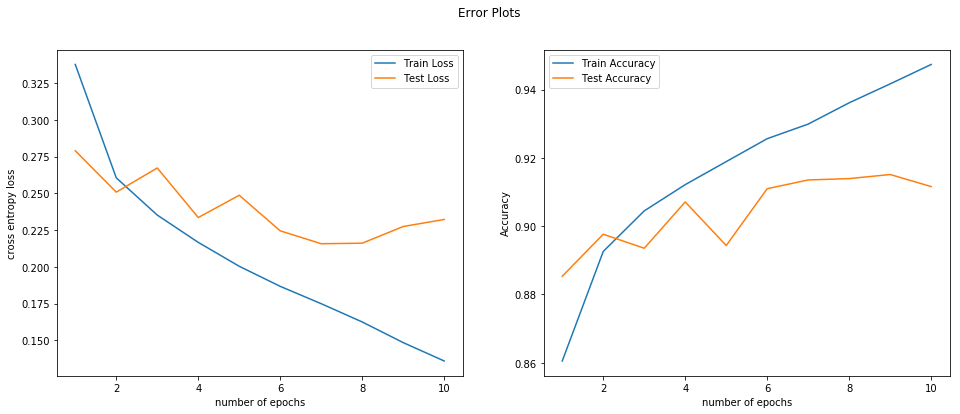

In [ ]:
plot_graph(history,model)

### CONCLUSIONS:


*   As we can see our model overfits badly we need to set some parameters to reduce overfitting.
*   We will set learning rates,dropouts for Lstm layer to reduce the extent of overfitting.


---





### [7.2]Creating common model

In [ ]:
def create_model(nu_lstm_layers,units,dropout,rec_drop,lear_rate,early_stopping):
  
  #the other dimension of the shape defines the number of samples / batch size that will be declared during fit
  ip_layer=Input(shape=(sequence_length,))    

  embd_lyr=Embedding(input_dim=vocab_size,output_dim=100,trainable=False,weights=[weights],input_length=600)(ip_layer)
  
  ret_seq=False
  
  if nu_lstm_layers>1:
    ret_seq=True
    
  lstm_lyr_1=LSTM(units=units[0],dropout=dropout,recurrent_dropout=rec_drop,return_sequences=ret_seq)(embd_lyr)

  if nu_lstm_layers==2:
    
    lstm_lyr_2=LSTM(units=units[1],dropout=dropout,recurrent_dropout=rec_drop,return_sequences=False)(lstm_lyr_1)
    
    output_lyr=Dense(1,activation='sigmoid')(lstm_lyr_2)
 
  else :
    
    output_lyr=Dense(1,activation='sigmoid')(lstm_lyr_1)
    

  model=Model(inputs=ip_layer,outputs=output_lyr)
  
  print(model.summary())
  
  model.compile(optimizer=Adam(lr=lear_rate),loss='binary_crossentropy',metrics=['accuracy'])
  
  
  #creating a callback list to avoid model performance to degrade
  cb_list=[]
  
  if early_stopping[0]:
    es=EarlyStopping(monitor=early_stopping[1],verbose=0,patience=4,mode='min')
    cb_list.append(es)
    
  history=model.fit(X_train_new,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test_new,y_test),verbose=1,callbacks=cb_list)
  
  return history,model

### [7.3] Trying various Learning rates:

In [ ]:
#learning rate=0.001
history1,model1=create_model(1,[100],0.0,0.0,0.001,(False,'val_loss'))

W0906 12:03:50.500355 139996524390272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 12:03:50.506817 139996524390272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 12:03:50.518090 139996524390272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0906 12:03:50.538342 139996524390272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0906 12:03:50.542285 1399965243

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 580,601
Trainable params: 80,501
Non-trainable params: 500,100
_________________________________________________________________
None
Train on 70218 samples, validate on 17555 samples
Epoch 1/10
70218/70218 [==============================] - 480s 7ms/step - loss: 0.3339 - acc: 0.8638 - val_loss: 0.3076 - val_acc: 0.8848
Epoch 2/10
70218/70218 [=============================

In [ ]:
plot_graph(history1,model1)

NameError: ignored

In [ ]:
#learning rate 0.0001
history2,model2=create_model(1,[100],0.0,0.0,0.0001,(False,'val_loss'))






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 580,601
Trainable params: 80,501
Non-trainable params: 500,100
_________________________________________________________________
None

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 70218 samples, validate on 17555 samples
Epoch 1/10
70218/70218 [==============================] - 426s 6ms/step - loss: 0.4071 - ac

test log-loss  0.2580425764948376
test accuracy  0.8923383651619045


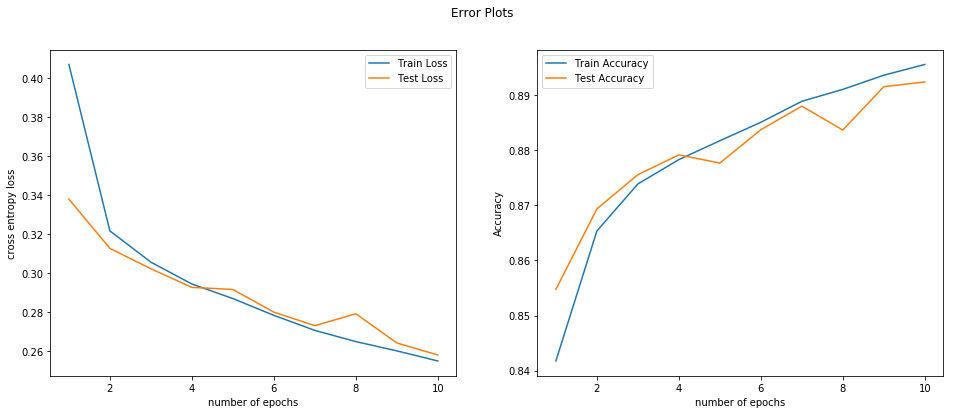

In [ ]:
plot_graph(history2,model2)

In [ ]:
#learning rate 0.01
history3,model3=create_model(1,[100],0.0,0.0,0.01,(False,'val_loss'))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 580,601
Trainable params: 80,501
Non-trainable params: 500,100
_________________________________________________________________
None
Train on 70218 samples, validate on 17555 samples
Epoch 1/10
70218/70218 [==============================] - 442s 6ms/step - loss: 0.2869 - acc: 0.8835 - val_loss: 0.2610 - val_acc: 0.8926
Epoch 2/10
70218/70218 [=============================

test log-loss  0.2506699140867729
test accuracy  0.9068071774660913


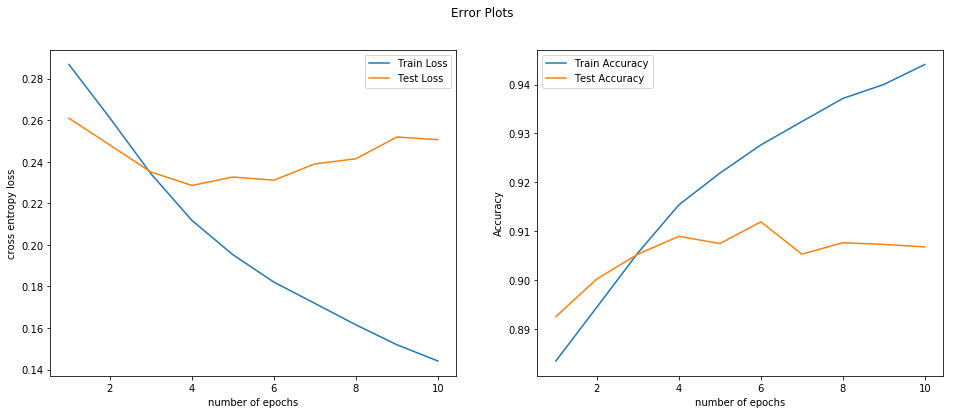

In [ ]:
plot_graph(history3,model3)



### CONCLUSIONS:


*   Learning rate of 0.001 and 0.0001 helps in reducing the extent of overfitting.
*   Still we can perform dropout on the LSTM layer to provide some better regularization.


---








### [7.4] Trying Different Dropout Rates

In [ ]:
#dropout 0.1 and learning_rate=0.001

history4,model4=create_model(1,[100],0.1,0.0,0.001,(False,'val_loss'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 580,601
Trainable params: 80,501
Non-trainable params: 500,100
_________________________________________________________________
None

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 70218 samples, va

test log-loss  0.213105740380131
test accuracy  0.916434064352149


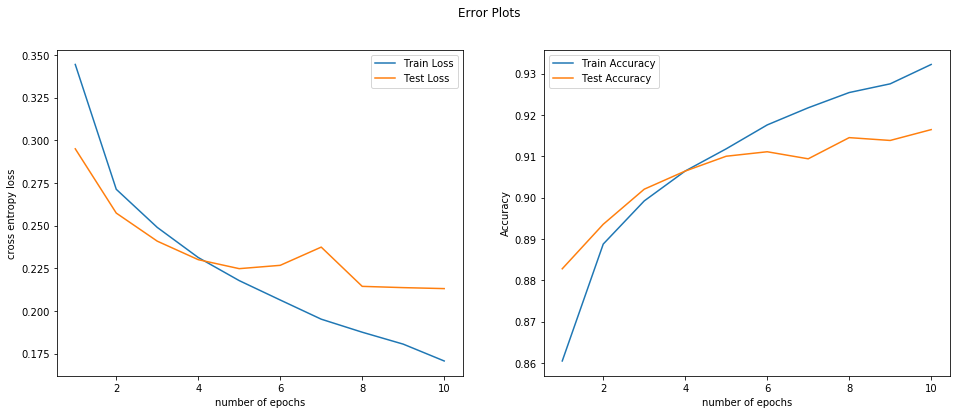

In [ ]:
plot_graph(history4,model4)

In [ ]:
#drp=0.2 lear_rate=0.001
history5,model5=create_model(1,[100],0.2,0.0,0.001,(False,'val_loss'))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 580,601
Trainable params: 80,501
Non-trainable params: 500,100
_________________________________________________________________
None
Train on 70218 samples, validate on 17555 samples
Epoch 1/10
70218/70218 [==============================] - 469s 7ms/step - loss: 0.3482 - acc: 0.8571 - val_loss: 0.2905 - val_acc: 0.8784
Epoch 2/10
70218/70218 [=============================

test log-loss  0.20829926486437697
test accuracy  0.9179720877480623


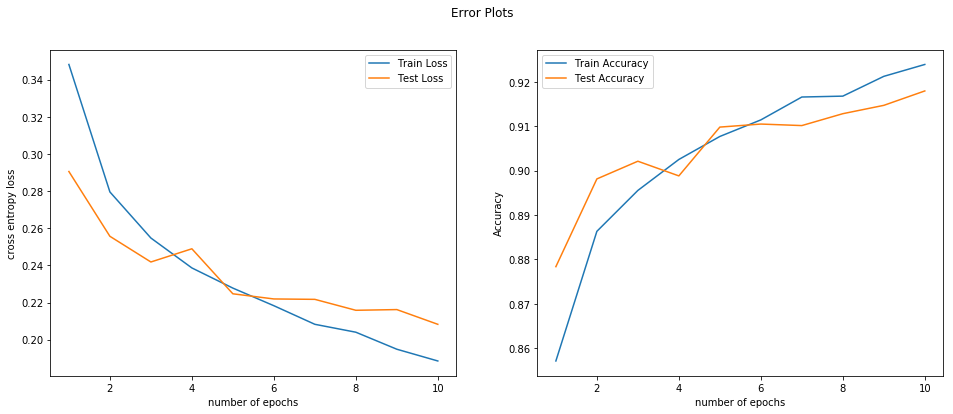

In [ ]:
plot_graph(history5,model5)

In [ ]:
#drp rate=0.3 lear_rate=0.001
history8,model8=create_model(1,[100],0.3,0.0,0.001,(False,'val_loss'))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 580,601
Trainable params: 80,501
Non-trainable params: 500,100
_________________________________________________________________
None
Train on 70218 samples, validate on 17555 samples
Epoch 1/10
70218/70218 [==============================] - 473s 7ms/step - loss: 0.3630 - acc: 0.8520 - val_loss: 0.2904 - val_acc: 0.8807
Epoch 2/10
70218/70218 [=============================

test log-loss  0.21101638491474234
test accuracy  0.915465679276672


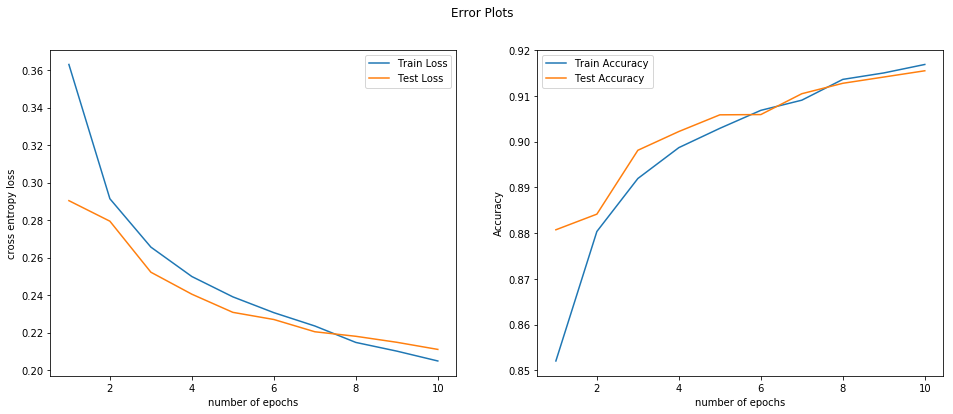

In [ ]:
plot_graph(history8,model8)

In [ ]:
#drp=0.1 lear_rate=0.0001
history6,model6=create_model(1,[100],0.1,0.0,0.0001,(False,'val_loss'))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 580,601
Trainable params: 80,501
Non-trainable params: 500,100
_________________________________________________________________
None
Train on 70218 samples, validate on 17555 samples
Epoch 1/10
70218/70218 [==============================] - 487s 7ms/step - loss: 0.4303 - acc: 0.8329 - val_loss: 0.3563 - val_acc: 0.8456
Epoch 2/10
70218/70218 [=============================

test log-loss  0.26932562698889445
test accuracy  0.8897180290345758


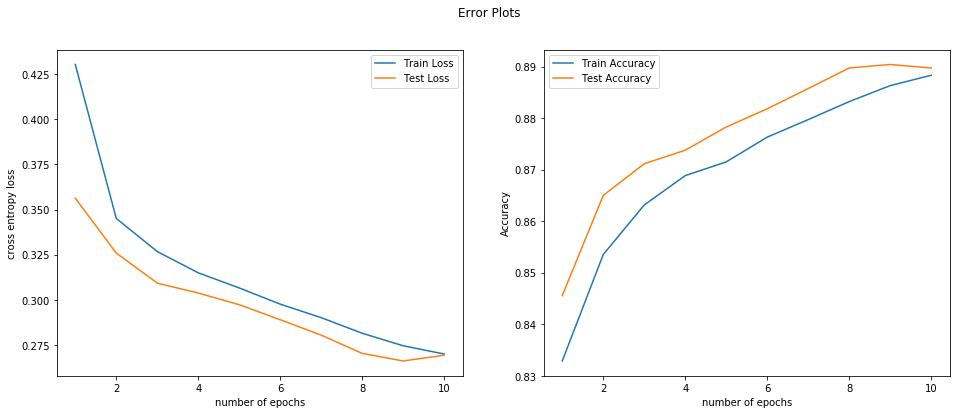

In [ ]:
plot_graph(history6,model6)

In [ ]:
#drp rate=0.2 lear_rate=0.0001
history7,model7=create_model(1,[100],0.2,0.0,0.0001,(False,'val_loss'))

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 580,601
Trainable params: 80,501
Non-trainable params: 500,100
_________________________________________________________________
None
Train on 70218 samples, validate on 17555 samples
Epoch 1/10
70218/70218 [==============================] - 476s 7ms/step - loss: 0.4463 - acc: 0.8143 - val_loss: 0.3763 - val_acc: 0.8404
Epoch 2/10
70218/70218 [=============================

test log-loss  0.27029284757788247
test accuracy  0.8893762460667602


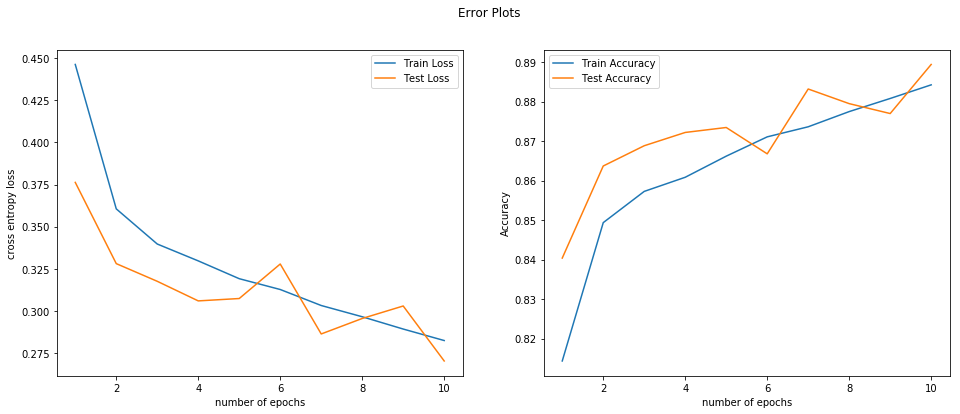

In [ ]:
plot_graph(history7,model7)

In [ ]:
#lear_rate=0.0001 dropout=0.3
history9,model9=create_model(1,[100],0.3,0.0,0.0001,(False,'val_loss'))

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 580,601
Trainable params: 80,501
Non-trainable params: 500,100
_________________________________________________________________
None
Train on 70218 samples, validate on 17555 samples
Epoch 1/10
70218/70218 [==============================] - 479s 7ms/step - loss: 0.4415 - acc: 0.8293 - val_loss: 0.3760 - val_acc: 0.8388
Epoch 2/10
70218/70218 [=============================

test log-loss  0.2736967801377156
test accuracy  0.8877242950556523


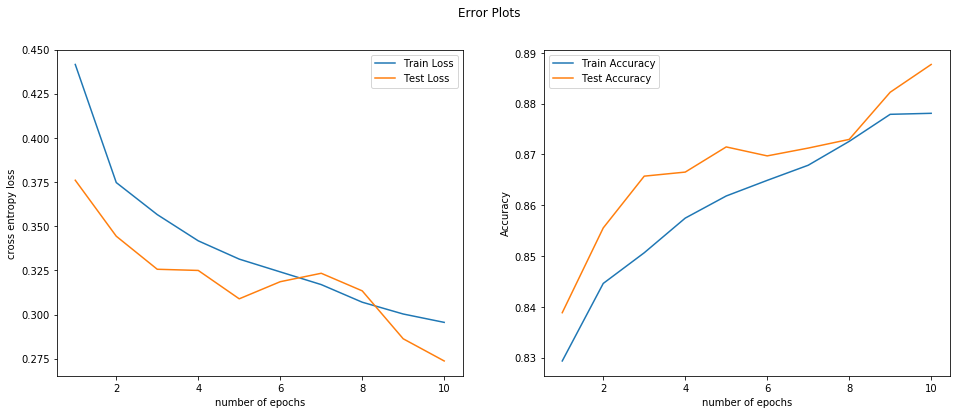

In [ ]:
plot_graph(history9,model9)

In [ ]:
#lear_rate=0.001 and dropout rate=0.4
history10,model10=create_model(1,[100],0.4,0.0,0.001,(False,'val_loss'))

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 580,601
Trainable params: 80,501
Non-trainable params: 500,100
_________________________________________________________________
None
Train on 70218 samples, validate on 17555 samples
Epoch 1/10
70218/70218 [==============================] - 477s 7ms/step - loss: 0.3737 - acc: 0.8477 - val_loss: 0.2961 - val_acc: 0.8802
Epoch 2/10
70218/70218 [=============================

test log-loss  0.260903511511502
test accuracy  0.8902307035270426


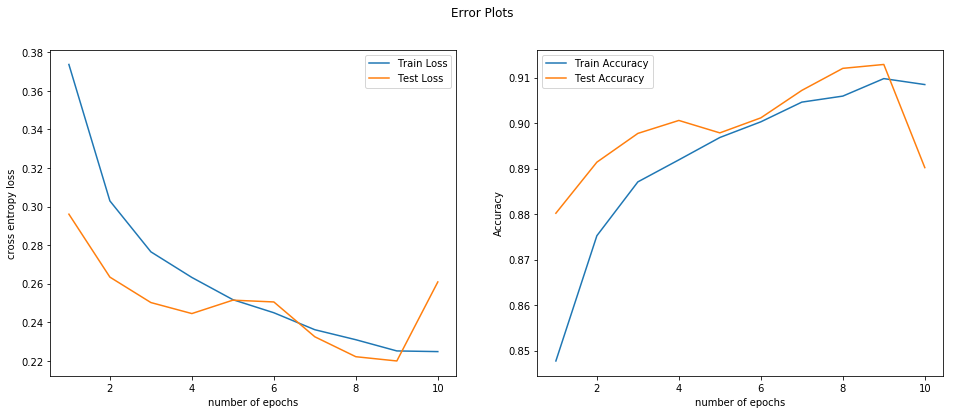

In [ ]:
plot_graph(history10,model10)

### CONCLUSIONS:



*   Clearly as we can observe from the loss plots that adding some fraction of dropout has reduce overfitting.
*   Learning rate 0.001 with dropout 0.3 has produced very good results and Learning rate 0.0001 with dropout rate 0.1 also produced nice results.
* There is clearly a tradeoff between learning rate and dropout rate.


---





### [7.5] Trying 2 LSTM layers:

In [ ]:
history11,model11=create_model(nu_lstm_layers=2,units=[100,50],dropout=0.3,rec_drop=0.0,lear_rate=0.001,early_stopping=(True,'val_loss'))

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_14 (LSTM)               (None, 600, 100)          80400     
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 610,751
Trainable params: 110,651
Non-trainable params: 500,100
_________________________________________________________________
None
Train on 70218 samples, validate on 17555 samples
Epoch 1/10
70218/70218 [==============================] - 

test log-loss  0.20957525061325144
test accuracy  0.9140985474291774


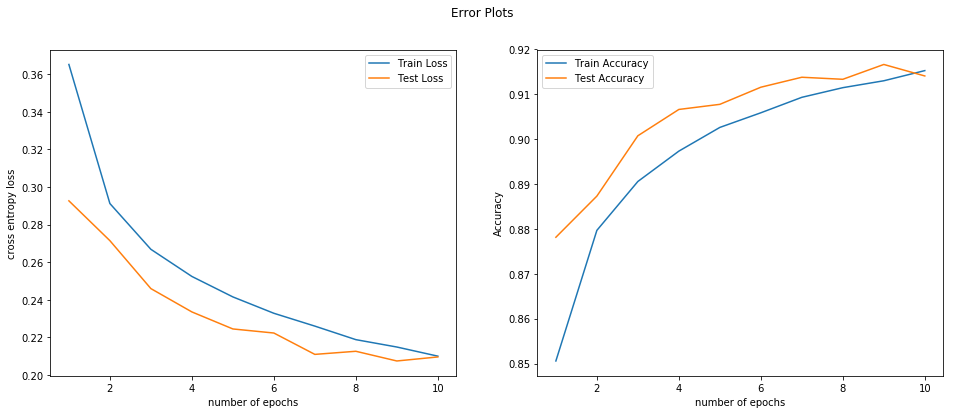

In [ ]:
plot_graph(history11,model11)

In [ ]:
history12,model12=create_model(nu_lstm_layers=2,units=[100,50],dropout=0.1,rec_drop=0.0,lear_rate=0.0001,early_stopping=(True,'val_loss'))

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 600, 100)          500100    
_________________________________________________________________
lstm_16 (LSTM)               (None, 600, 100)          80400     
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 610,751
Trainable params: 110,651
Non-trainable params: 500,100
_________________________________________________________________
None
Train on 70218 samples, validate on 17555 samples
Epoch 1/10
70218/70218 [==============================] - 

test log-loss  0.2620800776126479
test accuracy  0.8906294503058507


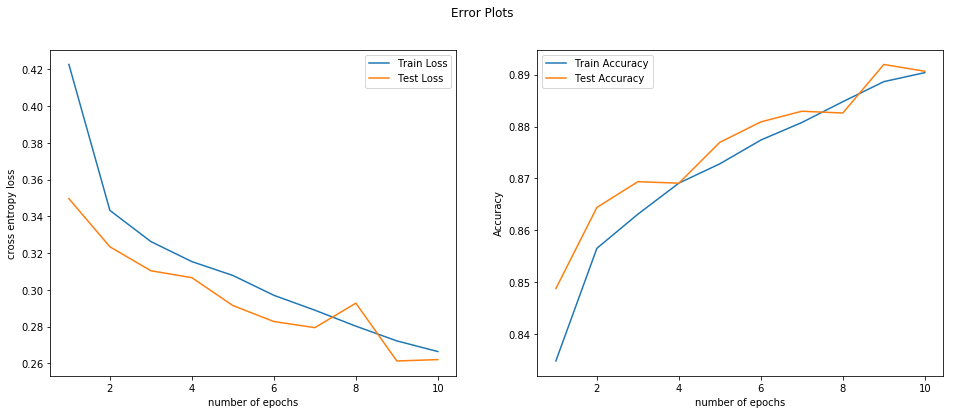

In [ ]:
plot_graph(history12,model12)